## Configuration for Colab

Check out: https://github.com/MrSyee/pg-is-all-you-need/

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install gymnasium==1.0.0

# 03. DDPG

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)).

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters.

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Replay buffer
One challenge when using neural networks for reinforcement learning is that most optimization algorithms assume that **the samples are independently and identically distributed**. When the samples are generated from exploring sequentially in an environment this assumption no longer holds. The authors used a **replay buffer** to address these issues. Transitions were sampled from the environment according to the exploration policy and the tuple $(s_t, a_t, r_t, s_{t+1})$ was stored in the replay buffer. At each timestep the actor and critic are updated by sampling a minibatch uniformly from the buffer. It allows to benefit from learning across a set of **uncorrelated** transitions.

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

## Import modules

In [6]:
import copy
import random
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference:
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [7]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, act_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size

## OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference:
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(self, size: int, mu: float = 0.0, theta: float = 0.15, sigma: float = 0.2):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

## Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [9]:
class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()

        return action

class Critic(nn.Module):
    def __init__(
        self,
        in_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [10]:
class DDPGAgent:
    """DDPGAgent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
        seed (int): random seed
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        seed: int = 777,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, action_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.seed = seed

        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = (
                self.actor(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
            )

        # add noise for exploration during training
        # TODO: [START] CODE HERE
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)
        # TODO: [END]   CODE HERE

        self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # Calculate target Q
        # TODO: [START] CODE HERE
        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks
        # TODO: [END]   CODE HERE

        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # target update
        self._target_soft_update()

        """
        Основные сети -(быстрое обновление)-> Основные сети
            |
            |(медленное обновление через tau)
            ↓
        Целевые сети -(медленное обновление)-> Целевые сети
        """

        return actor_loss.data, critic_loss.data

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size and self.total_step > self.initial_random_steps:
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss.cpu().numpy())
                critic_losses.append(critic_loss.cpu().numpy())

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step,
                    scores,
                    actor_losses,
                    critic_losses,
                )

        self.env.close()

    def test(self, video_folder: str):
        """Test the agent."""
        self.is_test = True

        tmp_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = tmp_env

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau

        for t_param, l_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [11]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        # TODO: [START] CODE HERE
        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor
        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)
        # TODO: [END]   CODE HERE

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        # TODO: [START] CODE HERE
        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        # TODO: [END]   CODE HERE

        return action

You can see [the code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/e73245912087d47b538dcdb45fa9a9d185b805c5/gymnasium/envs/__init__.py#L41) of Pendulum-v1 from Gymnasyim repository.

In [12]:
# environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = ActionNormalizer(env)

## Set random seed

In [14]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True


seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

## Initialize

In [15]:
# parameters
num_frames = 50_000
memory_size = 100_000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10_000

agent = DDPGAgent(
    env,
    memory_size,
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps,
    seed=seed,
)

cpu


## Train

In [16]:
agent.train(num_frames)

KeyboardInterrupt: 

## Test
Run the trained agent (1 episode).

In [13]:
# test
video_folder = "videos/ddpg"
agent.test(video_folder=video_folder)

Moviepy - Building video /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/ddpg/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/ddpg/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/ddpg/rl-video-episode-0.mp4
score:  -127.49513569656946


## Render

In [14]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(
        HTML(
            data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(
                encoded.decode("ascii")
            )
        )
    )


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/ddpg/rl-video-episode-0.mp4


# 04. TD3

[Fujimoto, Scott, Herke van Hoof, and David Meger. "Addressing function approximation error in actor-critic methods." arXiv preprint arXiv:1802.09477 2018.](https://arxiv.org/pdf/1802.09477.pdf)

In value-based reinforcement learning methods, function approximation errors are known to lead to overestimated value estimates and suboptimal policies. However, similar issues with actor-critic methods in continuous control domains have been largely left untouched (See paper for detailed description). To solve this problem, this paper proposes *a clipped Double Q-learning*. In addtion, this paper contains a number of components that address variance reduction.

The author's modifications are applied to actor-critic method for continuous control, Deep Deterministic Policy Gradient algorithm ([DDPG](https://arxiv.org/pdf/1509.02971.pdf)), to form the *Twin Delayed Deep Deterministic policy gradient algorithm (TD3)*.

### DDPG
For learning in high-dimentional and continous action spaces, the authors of DDPG combine the actor-critic approach with insights from the success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). Please see *03.DDP* for detailed description of DDPG.

### Double Q-learning
In Double DQN ([Van Hasselt et al., 2016](https://arxiv.org/pdf/1509.06461.pdf)), the authors propose using the target network as one of the value estimates, and obtain a policy by greedy maximization of the current value network rather than the target network. In an actor-critic setting, an analogous update uses the current policy rather than the target policy in the learning target. However, with the slow-changing policy in actor-critic, the current and target networks were too similar to make an independent estimation, and offered little improvement. Instead, the original Double Q-learning formulation can be used, with a pair of actors $(\pi_{\phi_1}, \pi_{\phi_2})$ and critics $(Q_{\theta_1}, Q_{\theta_2})$, where $\pi_{\phi_1}$ is optimized with respect to $Q_{\theta_1}$ and $\pi_{\phi_2}$ with respect to $Q_{\theta_2}$:

$$
y_1 = r + \gamma Q_{\theta'_2} (s' , \pi_{\phi_1}(s')) \\
y_2 = r + \gamma Q_{\theta'_1} (s' , \pi_{\phi_2}(s'))
$$

### A clipped Double Q-learning
The critics are not entirely independent, due to the use of the opposite critic in the learning targets, as well as the same replay buffer. As a result, for some states we will have $Q_{\theta'_2}(s, \pi_{\phi_1}) > Q_{\theta'_1}(s, \pi_{\phi_1})$. This is problematic because $Q_{\theta'_1}(s, \pi_{\phi_1})$ will generally overestimate the true value, and in certain areas of the state space the overestimation will be further exaggerated. To address this problem, the authors propose to take the minimum between the two estimates:

$$
y_1 = r + \gamma \underset{i=1,2}{\min} Q_{\theta'_i} (s' , \pi_{\phi_1}(s'))
$$

### Delayed Policy Updates
If policy updates on high-error states cause different behavior, then the policy network should be updated at a lower frequency than the value network, to first minimize error before introducing a policy update. The authors propose delaying policy updates until the value error is as small as possible.

### Target Policy Smoothing Regularization
When updating the critic, a learning target using a deterministic policy is highly susceptible to in accuracies induced by function approximation error, increasing the variance of the target. This induced variance can be reduced through regularization. The authors propose that fitting the value of a small area around the target action

$$
y = r + E_\epsilon [Q_{\theta'}(s', \pi_{\phi '}(s') + \epsilon],
$$

would have the benefit of smoothing the value estimate by bootstrapping off of similar state-action value estimates. In practice, this makes below:

$$
y = r + \gamma Q_{\theta '}(s', \pi_{\phi '}(s') + \epsilon), \\
\epsilon \sim \text{clip} (\mathcal(N)(0, \sigma), -c, c),
$$

where the added noise is clipped to keep the target close tothe original action.

## import module

In [18]:
import copy
import os
import random
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference:
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [19]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, act_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size

## Gaussian Noise
Because the DDPG and the TD3 policy is deterministic, it's not enough to explore a wide variety of actions. In order to facilitate more exploration. TD3 adds Gaussian noise to each action, while DDPG uses Ornstein-Uhlenbeck noise. The TD3 paper states Ornstein-Uhlenbeck noise offered no performance benefits.

In [20]:
class GaussianNoise:
    """Gaussian Noise.
    Taken from https://github.com/vitchyr/rlkit
    """

    def __init__(
        self,
        action_dim: int,
        min_sigma: float = 1.0,
        max_sigma: float = 1.0,
        decay_period: int = 1000000,
    ):
        """Initialize."""
        self.action_dim = action_dim
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period

    def sample(self, t: int = 0) -> float:
        """Get an action with gaussian noise."""
        sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.random.normal(0, sigma, size=self.action_dim)

## Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, *ReLU* for hidden layers and *tanh* for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers *ReLU*. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are *uniformly distributed.*

In [21]:
class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()

        return action


class Critic(nn.Module):
    def __init__(self, in_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## TD3Agent
Here is a summary of TD3Agent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [22]:
class TD3Agent:
    """TD3Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        actor1 (nn.Module): target actor model to select actions
        actor2 (nn.Module): target actor model to select actions
        actor_target1 (nn.Module): actor model to predict next actions
        actor_target2 (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic1 (nn.Module): critic model to predict state values
        critic2 (nn.Module): critic model to predict state values
        critic_target1 (nn.Module): target critic model to predict state values
        critic_target2 (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        exploration_noise (GaussianNoise): gaussian noise for policy
        target_policy_noise (GaussianNoise): gaussian noise for target policy
        target_policy_noise_clip (float): clip target gaussian noise
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        policy_update_freq (int): update actor every time critic updates this times
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
        seed (int): random seed
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        exploration_noise: float = 0.1,
        target_policy_noise: float = 0.2,
        target_policy_noise_clip: float = 0.5,
        initial_random_steps: int = int(1e4),
        policy_update_freq: int = 2,
        seed: int = 777,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, action_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.policy_update_freq = policy_update_freq
        self.seed = seed

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # noise
        self.exploration_noise = GaussianNoise(action_dim, exploration_noise, exploration_noise)
        self.target_policy_noise = GaussianNoise(
            action_dim, target_policy_noise, target_policy_noise
        )
        self.target_policy_noise_clip = target_policy_noise_clip

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic1 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target1 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target1.load_state_dict(self.critic1.state_dict())

        self.critic2 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target2 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target2.load_state_dict(self.critic2.state_dict())

        # concat critic parameters to use one optim
        critic_parameters = list(self.critic1.parameters()) + list(self.critic2.parameters())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(critic_parameters, lr=1e-3)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # update step for actor
        self.update_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = (
                self.actor(torch.FloatTensor(state).to(self.device))[0].detach().cpu().numpy()
            )

        # add noise for exploration during training
        if not self.is_test:
            noise = self.exploration_noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)

            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        states = torch.FloatTensor(samples["obs"]).to(device)
        next_states = torch.FloatTensor(samples["next_obs"]).to(device)
        actions = torch.FloatTensor(samples["acts"]).to(device)
        rewards = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        dones = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        masks = 1 - dones

        # get actions with noise
        noise = torch.FloatTensor(self.target_policy_noise.sample()).to(device)
        clipped_noise = torch.clamp(
            noise, -self.target_policy_noise_clip, self.target_policy_noise_clip
        )

        next_actions = (self.actor_target(next_states) + clipped_noise).clamp(-1.0, 1.0)

        # min (Q_1', Q_2')
        next_values1 = self.critic_target1(next_states, next_actions)
        next_values2 = self.critic_target2(next_states, next_actions)
        next_values = torch.min(next_values1, next_values2)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_returns = rewards + self.gamma * next_values * masks
        curr_returns = curr_returns.detach()

        # critic loss
        values1 = self.critic1(states, actions)
        values2 = self.critic2(states, actions)
        critic1_loss = F.mse_loss(values1, curr_returns)
        critic2_loss = F.mse_loss(values2, curr_returns)

        # train critic
        critic_loss = critic1_loss + critic2_loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.total_step % self.policy_update_freq == 0:
            # train actor
            actor_loss = -self.critic1(states, self.actor(states)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # target update
            self._target_soft_update()
        else:
            actor_loss = torch.zeros(())

        return actor_loss.data, critic_loss.data

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size and self.total_step > self.initial_random_steps:
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss.cpu().numpy())
                critic_losses.append(critic_loss.cpu().numpy())

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)

        self.env.close()

    def test(self, video_folder: str):
        """Test the agent."""
        self.is_test = True

        tmp_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = tmp_env

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        for t_param, l_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(self.critic_target1.parameters(), self.critic1.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(self.critic_target2.parameters(), self.critic2.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(30, 5))
        plt.subplot(131)
        plt.title("frame %s. score: %s" % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title("actor_loss")
        plt.plot(actor_losses)
        plt.subplot(133)
        plt.title("critic_loss")
        plt.plot(critic_losses)
        plt.show()

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [23]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/e73245912087d47b538dcdb45fa9a9d185b805c5/gymnasium/envs/__init__.py#L41) of Pendulum-v1 from Gymnasyim repository.

In [24]:
# environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = ActionNormalizer(env)

## Set random seed

In [25]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True


seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

## Initialize

In [23]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 128
initial_random_steps = 10000

agent = TD3Agent(env, memory_size, batch_size, initial_random_steps=initial_random_steps, seed=seed)

cpu


## Train

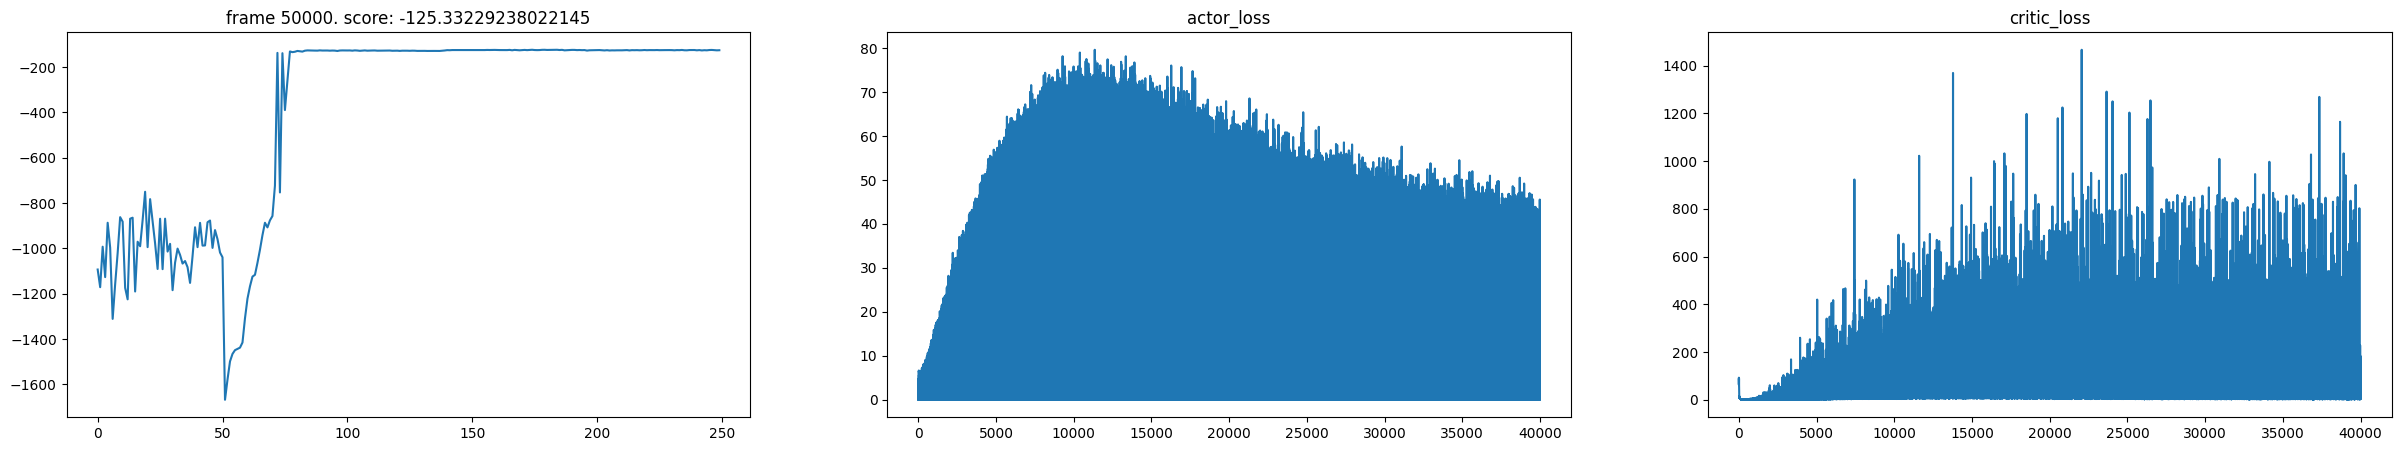

In [24]:
agent.train(num_frames)

## Test
Run the trained agent (1 episode).

In [25]:
# test
video_folder = "videos/td3"
agent.test(video_folder=video_folder)

Moviepy - Building video /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/td3/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/td3/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/td3/rl-video-episode-0.mp4
score:  -126.45370484457233


## Render

In [26]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(
        HTML(
            data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(
                encoded.decode("ascii")
            )
        )
    )


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/td3/rl-video-episode-0.mp4


# 05. Soft Actor Critic (SAC)

1. [T. Haarnoja et al., "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." arXiv preprint arXiv:1801.01290, 2018.](https://arxiv.org/pdf/1801.01290.pdf)
2. [T. Haarnoja et al., "Soft Actor-Critic Algorithms and Applications." arXiv preprint arXiv:1812.05905, 2018.](https://arxiv.org/pdf/1812.05905.pdf)

The main purpose of SAC is to maximize the actor's entropy while maximizing expected reward. We can expect both sample efficient learning and stability because maximizing entropy provides a substantial improvement in exploration and robustness.

As an extension of standard RL's objective function $\sum_t \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t)]$, let's consider a more general maximum entropy objective which favors stochastic policies by augmenting the objective with the expected entropy of the policy over $\rho_\pi (s_t)$:

$$J(\pi) = \sum_{t=0}^T \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t) + \alpha H(\pi(\cdot | s_t))].$$

The temperature parameter $\alpha$ determines the relative importance of the entropy term against the reward, and thus controls the stochasticity of the optimal policy. By this objective, the policy can explore more widely and capture multiple modes of near-optimal behavior. In conclusion, it considerably improves learning speed over other methods that optimize the conventional RL objective function.

In the paper, the authors show that *Soft Policy Iteration* guarantees convergence based on a tabular setting (4.1), and they extend it to a practical approximation for large continuous domains (4.2). Firstly, the soft value function is trained to minimize the squared residual error:

$$J_V (\psi) = \mathbb{E}_{s_t \sim D} \big[ \frac{1}{2}(v_\psi (s_t) - \mathbb{E}_{a_t \sim \pi_\phi} [Q_\theta(s_t, a_t) - \log_{\pi_\phi}(a_t | s_t)])^2 \big],$$

where $D$ is the distribution of previously sampled states and actions, or a replay buffer. Second, the soft Q-function parameters can be trained to minimize the soft Bellman residual:

$$J_Q (\theta) = \mathbb{E}_{(s_t, a_t) \sim D} \big[ \frac{1}{2} \big( Q_\theta(s_t, a_t) - \hat{Q}(s_t, a_t) \big)^2 \big],$$

with $\hat{Q}(s_t, a_t) = r(s_t, a_t) + \gamma \mathbb{E}_{s_{t+1} \sim \rho} [V_{\tilde{\psi}} (s_{t+1})].$

Finally, the policy paramameters can be learned by directly minimizing the following expected KL-divergence:

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D} \big[ D_{KL} \big( \pi_{\phi} (\cdot | s_t) \| \frac{\exp(Q_{\theta}(s_t, \cdot))}{Z_\theta(s_t)} \big) \big].$$

We can rewirte the objective as

$$J_\pi(\phi) = \mathbb{E}_{s_t \sim D, \epsilon_t \sim N} [ \log_{\pi_\phi}(f_\phi(\epsilon_t ; s_t) | s_t) - Q_\theta (s_t, f_\phi (\epsilon_t ; s_t))],$$

where $\pi_\phi$ is defined implicitly in terms of $f_\phi$, and the partition function is independent of $\phi$ and can thus be omitted.

One thing to note is that the authors suggest to use two Q-functions to mitigate positive bias in the policy improvement step that is known to degrade performance of value based methods. In particular, we parameterize two Q-functions, with parameters $\theta_i$, and train them independently to optimize $J_Q(\theta_i)$. We then use the minimum of the Q-functions for the value gradient and policy gradient. Two Q-functions can significantly speed up training, especially on harder tasks.

### Can we do better?

In Soft Actor Critic paper, the experiment of reward scale shows that SAC's performance quite varies depending on reward scaling. In the follow-up paper [2], the authors assume that the temperature parameter $\alpha$ needs to be adjusted depending on the magnitude of the reward, and they define the soft policy optimization as a constrained problem.

$$\max_{\pi_{0:T}} \mathbb{E}_{\rho_\pi} \big[ \sum_{t=0}^T r(s_t, a_t) \big] \text{ s.t. } \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [-\log(\pi_t(a_t|s_t))] \ge H \text{ for all } t,$$

where $H$ is a desired minimum expected entropy. This constrained maximization becomes the following dual problem.

$$\min_{a_T \ge 0} \max_{\pi_T} \mathbb{E} [r(s_T, a_T) - \alpha_T \log \pi(a_t|s_t)] - \alpha_T H,$$

where $\alpha_T$ is the dual variable. Furthermore, it can be rewrited as a optimization problem with regards to $\alpha$.

$$J(\alpha) = \mathbb{E}_{a_t \sim \pi_t} [-\alpha \log \pi_t (a_t | s_t) - \alpha H].$$

By optimizing this dual problem, we can adjust the dual variable $\alpha$, which plays the role of the temperature.

## Import modules

In [26]:
import random
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference:
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [27]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, act_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size

## Network
We are going to use three different networks for policy, Q-function, and V-function. We use two Q-functions to mitigate positive bias and softly update V-function for stable learning. One interesting thing is that the policy network works as Tanh Normal distribution which enforces action bounds. (The details are descibed in Appendix C of [2].)

In [28]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer


class Actor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        log_std_min: float = -20,
        log_std_max: float = 2,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        # set the log std range
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        # set the hidden layers
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)

        # set log_std layer
        self.log_std_layer = nn.Linear(128, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

        # set mean layer
        self.mu_layer = nn.Linear(128, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))

        # get mean
        mu = self.mu_layer(x).tanh()

        # get std
        log_std = self.log_std_layer(x).tanh()
        log_std = self.log_std_min + 0.5 * (self.log_std_max - self.log_std_min) * (log_std + 1)
        std = torch.exp(log_std)

        # sample actions
        dist = Normal(mu, std)
        z = dist.rsample()

        # normalize action and log_prob
        # see appendix C of [2]
        action = z.tanh()
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-7)
        log_prob = log_prob.sum(-1, keepdim=True)

        return action, log_prob


class CriticQ(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(CriticQ, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value


class CriticV(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(CriticV, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## SAC Agent
Here is a summary of SACAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [29]:
class SACAgent:
    """SAC agent interacting with environment.

    Attrtibutes:
        actor (nn.Module): actor model to select actions
        actor_optimizer (Optimizer): optimizer for training actor
        vf (nn.Module): critic model to predict state values
        vf_target (nn.Module): target critic model to predict state values
        vf_optimizer (Optimizer): optimizer for training vf
        qf_1 (nn.Module): critic model to predict state-action values
        qf_2 (nn.Module): critic model to predict state-action values
        qf_1_optimizer (Optimizer): optimizer for training qf_1
        qf_2_optimizer (Optimizer): optimizer for training qf_2
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        policy_update_freq (int): policy update frequency
        device (torch.device): cpu / gpu
        target_entropy (int): desired entropy used for the inequality constraint
        log_alpha (torch.Tensor): weight for entropy
        alpha_optimizer (Optimizer): optimizer for alpha
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
        seed (int): random seed
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = int(1e4),
        policy_update_freq: int = 2,
        seed: int = 777,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, action_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.policy_update_freq = policy_update_freq
        self.seed = seed

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # automatic entropy tuning
        self.target_entropy = -np.prod((action_dim,)).item()  # heuristic
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=3e-4)

        # actor
        self.actor = Actor(obs_dim, action_dim).to(self.device)

        # v function
        self.vf = CriticV(obs_dim).to(self.device)
        self.vf_target = CriticV(obs_dim).to(self.device)
        self.vf_target.load_state_dict(self.vf.state_dict())

        # q function
        self.qf_1 = CriticQ(obs_dim + action_dim).to(self.device)
        self.qf_2 = CriticQ(obs_dim + action_dim).to(self.device)

        # optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.vf_optimizer = optim.Adam(self.vf.parameters(), lr=3e-4)
        self.qf_1_optimizer = optim.Adam(self.qf_1.parameters(), lr=3e-4)
        self.qf_2_optimizer = optim.Adam(self.qf_2.parameters(), lr=3e-4)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = (
                self.actor(torch.FloatTensor(state).to(self.device))[0].detach().cpu().numpy()
            )

        self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> Tuple[torch.Tensor, ...]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        new_action, log_prob = self.actor(state)

        # train alpha (dual problem)
        alpha_loss = (-self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        alpha = self.log_alpha.exp()  # used for the actor loss calculation

        # q function loss
        mask = 1 - done
        q_1_pred = self.qf_1(state, action)
        q_2_pred = self.qf_2(state, action)
        v_target = self.vf_target(next_state)
        q_target = reward + self.gamma * v_target * mask
        qf_1_loss = F.mse_loss(q_1_pred, q_target.detach())
        qf_2_loss = F.mse_loss(q_2_pred, q_target.detach())

        # v function loss
        v_pred = self.vf(state)
        q_pred = torch.min(self.qf_1(state, new_action), self.qf_2(state, new_action))
        v_target = q_pred - alpha * log_prob
        vf_loss = F.mse_loss(v_pred, v_target.detach())

        if self.total_step % self.policy_update_freq == 0:
            # actor loss
            advantage = q_pred - v_pred.detach()
            actor_loss = (alpha * log_prob - advantage).mean()

            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # target update (vf)
            self._target_soft_update()
        else:
            actor_loss = torch.zeros(())

        # train Q functions
        self.qf_1_optimizer.zero_grad()
        qf_1_loss.backward()
        self.qf_1_optimizer.step()

        self.qf_2_optimizer.zero_grad()
        qf_2_loss.backward()
        self.qf_2_optimizer.step()

        qf_loss = qf_1_loss + qf_2_loss

        # train V function
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step()

        return actor_loss.data, qf_loss.data, vf_loss.data, alpha_loss.data

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        actor_losses, qf_losses, vf_losses, alpha_losses = [], [], [], []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size and self.total_step > self.initial_random_steps:
                losses = self.update_model()
                actor_losses.append(losses[0].cpu().numpy())
                qf_losses.append(losses[1].cpu().numpy())
                vf_losses.append(losses[2].cpu().numpy())
                alpha_losses.append(losses[3].cpu().numpy())

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step, scores, actor_losses, qf_losses, vf_losses, alpha_losses
                )

        self.env.close()

    def test(self, video_folder: str):
        """Test the agent."""
        self.is_test = True

        tmp_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = tmp_env

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau

        for t_param, l_param in zip(self.vf_target.parameters(), self.vf.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        qf_losses: List[float],
        vf_losses: List[float],
        alpha_losses: List[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (151, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (152, "actor_loss", actor_losses),
            (153, "qf_loss", qf_losses),
            (154, "vf_loss", vf_losses),
            (155, "alpha_loss", alpha_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [30]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/e73245912087d47b538dcdb45fa9a9d185b805c5/gymnasium/envs/__init__.py#L41) of Pendulum-v1 from Gymnasyim repository.

In [31]:
# environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = ActionNormalizer(env)

## Set random seed

In [32]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True


seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

## Initialize

In [34]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 128
initial_random_steps = 10000

agent = SACAgent(env, memory_size, batch_size, initial_random_steps=initial_random_steps, seed=seed)

cpu


## Train

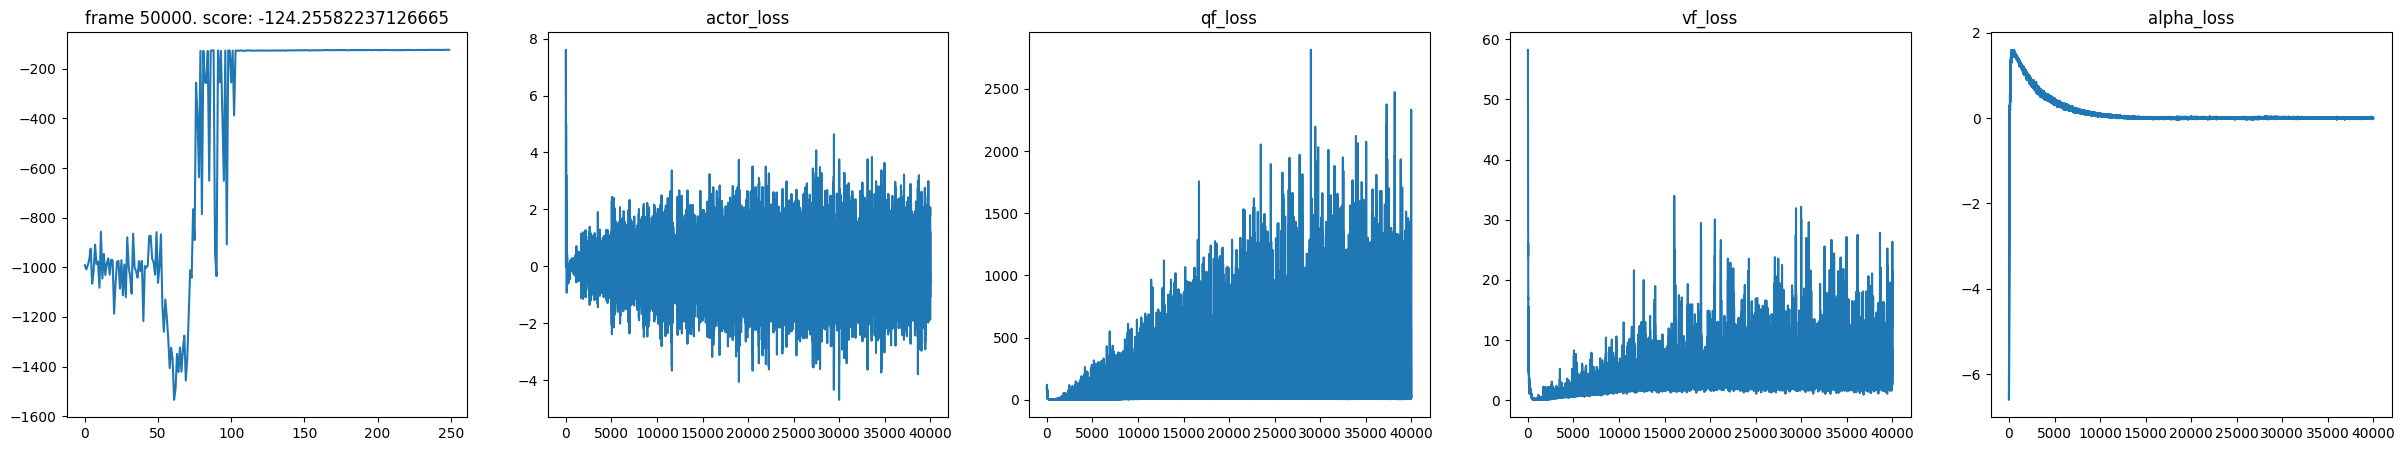

In [35]:
agent.train(num_frames)

## Test
Run the trained agent (1 episode).

In [36]:
# test
video_folder = "videos/sac"
agent.test(video_folder=video_folder)

Moviepy - Building video /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/sac/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/sac/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kurise/Work/AI-Masters/RL/seminar-7-sac/videos/sac/rl-video-episode-0.mp4
score:  -123.86980418481059


## Render

In [37]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(
        HTML(
            data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(
                encoded.decode("ascii")
            )
        )
    )


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/sac/rl-video-episode-0.mp4
